# Exploring the NHC Advisories and Sea Surface Height during Hurricane Irma

Created: 2017-09-09

Updated: 2022-05-27


This notebook aims to demonstrate how to create a simple interactive GIS map with the National Hurricane Center predictions [1] and the observed sea surface height from CO-OPS [2].


See https://tidesandcurrents.noaa.gov/quicklook/view.html?name=IRMA for the latest information on Irma.

1. http://www.nhc.noaa.gov/gis/
2. https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/


First we have to download the National Hurricane Center (NHC) GIS 5 day predictions data for Irma.

NHC codes storms are coded with 8 letter names:
- 2 char for region `al` &rarr; Atlantic
- 2 char for number `11` is Irma
- and 4 char for year, `2017`

Browse https://www.nhc.noaa.gov/gis/archive_wsurge.php?year=2017 to find other hurricanes code.

In [1]:
code = "al112017"
hurricane = "{}_5day".format(code)

In [2]:
import sys
from pathlib import Path
from urllib.request import urlopen, urlretrieve

import lxml.html


def url_lister(url):
    urls = []
    connection = urlopen(url)
    dom = lxml.html.fromstring(connection.read())
    for link in dom.xpath("//a/@href"):
        urls.append(link)
    return urls


def download(url, path):
    sys.stdout.write(fname + "\n")
    path = Path(path)
    if not path.is_file():
        urlretrieve(url, filename=str(path), reporthook=progress_hook(sys.stdout))
        sys.stdout.write("\n")
        sys.stdout.flush()


def progress_hook(out):
    """
    Return a progress hook function, suitable for passing to
    urllib.retrieve, that writes to the file object *out*.
    """

    def it(n, bs, ts):
        got = n * bs
        if ts < 0:
            outof = ""
        else:
            # On the last block n*bs can exceed ts, so we clamp it
            # to avoid awkward questions.
            got = min(got, ts)
            outof = "/%d [%d%%]" % (ts, 100 * got // ts)
        out.write("\r  %d%s" % (got, outof))
        out.flush()

    return it

In [3]:
nhc = "https://www.nhc.noaa.gov/gis/forecast/archive/"

# We don't need the latest file b/c that is redundant to the latest number.
fnames = [
    fname
    for fname in url_lister(nhc)
    if fname.startswith(hurricane) and "latest" not in fname
]

In [4]:
base = Path(".").joinpath("data", hurricane).resolve()

if not base.is_dir():
    base.mkdir(parents=True)

for fname in fnames:
    url = f"{nhc}/{fname}"
    path = base.joinpath(fname)
    download(url, path)

al112017_5day_001.zip
al112017_5day_002.zip
al112017_5day_003.zip
al112017_5day_004.zip
al112017_5day_005.zip
al112017_5day_006.zip
al112017_5day_007.zip
al112017_5day_008.zip
al112017_5day_009.zip
al112017_5day_010.zip
al112017_5day_011.zip
al112017_5day_012.zip
al112017_5day_013.zip
al112017_5day_014.zip
al112017_5day_015.zip
al112017_5day_016.zip
al112017_5day_017.zip
al112017_5day_018.zip
al112017_5day_018A.zip
al112017_5day_019.zip
al112017_5day_019A.zip
al112017_5day_020.zip
al112017_5day_020A.zip
al112017_5day_021.zip
al112017_5day_021A.zip
al112017_5day_022.zip
al112017_5day_022A.zip
al112017_5day_023.zip
al112017_5day_023A.zip
al112017_5day_024.zip
al112017_5day_025.zip
al112017_5day_026.zip
al112017_5day_026A.zip
al112017_5day_027.zip
al112017_5day_027A.zip
al112017_5day_028.zip
al112017_5day_028A.zip
al112017_5day_029.zip
al112017_5day_029A.zip
al112017_5day_030.zip
al112017_5day_030A.zip
al112017_5day_031.zip
al112017_5day_031A.zip
al112017_5day_032.zip
al112017_5day_032A.z

In the cells below we use `geopandas` to load the data we just downloaded. We will use only the prediction cone (`png`) and the track points (`pts`), but feel free to explore this data further, there is plenty more there.

In [5]:
import os

os.environ["CPL_ZIP_ENCODING"] = "UTF-8"
os.environ["TZ"] = "GMT0"

In [6]:
from glob import glob

import geopandas

cones, points = [], []
for fname in sorted(glob(str(base.joinpath(f"{hurricane}_*.zip")))):
    number = fname.split("_")[-1].split(".zip")[0]
    pgn = geopandas.read_file(f"{fname}!{code}-{number}_5day_pgn.shp")
    cones.append(pgn)

    pts = geopandas.read_file(f"{fname}!{code}-{number}_5day_pts.shp")
    # Only the first "obsevartion."
    points.append(pts.iloc[0])

Let's create a color code for the point track.

In [7]:
colors = {
    "Subtropical Depression": "yellow",
    "Tropical Depression": "yellow",
    "Tropical Storm": "orange",
    "Subtropical Storm": "orange",
    "Hurricane": "red",
    "Major Hurricane": "crimson",
}

Now we can get all the information we need from those GIS files. Let's start with the event dates.

In [8]:
import dateutil

start = points[0]["FLDATELBL"].strip(" AST")
end = points[-1]["FLDATELBL"].strip(" EDT")

start = dateutil.parser.parse(start)
end = dateutil.parser.parse(end)

And the bounding box to search the data.

In [9]:
from shapely.geometry import LineString
from shapely.ops import unary_union

last_cone = cones[-1]["geometry"].iloc[0]
track = LineString([point["geometry"] for point in points])

polygon = unary_union([last_cone, track])

# Add a buffer to find the stations along the track.
bbox = polygon.buffer(2).bounds

Note that the bounding box is derived from the track and the latest prediction cone.

In [10]:
strbbox = ", ".join(format(v, ".2f") for v in bbox)
print(f"bbox: {strbbox}\nstart: {start}\n  end: {end}")

bbox: -91.91, 14.40, -28.30, 39.45
start: 2017-08-30 08:00:00
  end: 2017-09-11 20:00:00


Now we need to build a filter with those parameters to find the observations along the Hurricane path. We still need to specify:

- the units for the observations;
- and the SOS name for the variables of interest.

Next, we can use `pyoos` to assemble a collector to download the data into a pandas `DataFrame`.

In [11]:
import cf_units
import pandas as pd
from ioos_tools.ioos import collector2table
from pyoos.collectors.coops.coops_sos import CoopsSos
from retrying import retry


# We need to retry in case of failure b/c the server cannot handle
# the high traffic during events like Irma.
@retry(stop_max_attempt_number=5, wait_fixed=3000)
def get_coops(start, end, sos_name, units, bbox, verbose=False):
    collector = CoopsSos()
    collector.set_bbox(bbox)
    collector.end_time = end
    collector.start_time = start
    collector.variables = [sos_name]
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    config = dict(
        units=units,
        sos_name=sos_name,
    )

    data = collector2table(
        collector=collector,
        config=config,
        col="{} ({})".format(sos_name, units.format(cf_units.UT_ISO_8859_1)),
    )

    # Clean the table.
    table = dict(
        station_name=[s._metadata.get("station_name") for s in data],
        station_code=[s._metadata.get("station_code") for s in data],
        sensor=[s._metadata.get("sensor") for s in data],
        lon=[s._metadata.get("lon") for s in data],
        lat=[s._metadata.get("lat") for s in data],
        depth=[s._metadata.get("depth", "NA") for s in data],
    )

    table = pd.DataFrame(table).set_index("station_name")
    if verbose:
        print("Collector offerings")
        print(f"{title}: {len(ofrs)} offerings")
    return data, table

In [12]:
ssh, ssh_table = get_coops(
    start=start,
    end=end,
    sos_name="water_surface_height_above_reference_datum",
    units=cf_units.Unit("meters"),
    bbox=bbox,
)

ssh_table

station_code  \
station_name                                           
Bermuda Biological Station                   2695535   
Atlantic City, NJ                            8534720   
Cape May, NJ                                 8536110   
Ship John Shoal, NJ                          8537121   
Brandywine Shoal Light, DE                   8555889   
...                                              ...   
Esperanza, Vieques Island, PR                9752695   
San Juan, La Puntilla, San Juan Bay, PR      9755371   
Magueyes Island, PR                          9759110   
Mayaguez, PR                                 9759394   
Mona Island                                  9759938   

                                                                             sensor  \
station_name                                                                          
Bermuda Biological Station               urn:ioos:sensor:NOAA.NOS.CO-OPS:2695535:N1   
Atlantic City, NJ                        urn:ioos:sensor:NOAA.NOS.CO-OPS:8534720:A1   
Cape May, NJ                             urn:ioos:sensor:NOAA.NOS.CO-OPS:8536110:A1   
Ship John Shoal, NJ                      urn:ioos:sensor:NOAA.NOS.CO-OPS:8537121:A1   
Brandywine Shoal Light, DE               urn:ioos:sensor:NOAA.NOS.CO-OPS:8555889:Y1   
...                                                                             ...   
Esperanza, Vieques Island, PR            urn:ioos:sensor:NOAA.NOS.CO-OPS:9752695:A1   
San Juan, La Puntilla, San Juan Bay, PR  urn:ioos:sensor:NOAA.NOS.CO-OPS:9755371:Y1   
Magueyes Island, PR                      urn:ioos:sensor:NOAA.NOS.CO-OPS:9759110:A1   
Mayaguez, PR                             urn:ioos:sensor:NOAA.NOS.CO-OPS:9759394:Y1   
Mona Island                              urn:ioos:sensor:NOAA.NOS.CO-OPS:9759938:N1   

                                             lon      lat depth  
station_name                                                     
Bermuda Biological Station              -64.6950  32.3700  None  
Atlantic City, NJ                       -74.4181  39.3567  None  
Cape May, NJ                            -74.9600  38.9683  None  
Ship John Shoal, NJ                     -75.3750  39.3050  None  
Brandywine Shoal Light, DE              -75.1130  38.9870  None  
...                                          ...      ...   ...  
Esperanza, Vieques Island, PR           -65.4714  18.0939  None  
San Juan, La Puntilla, San Juan Bay, PR -66.1164  18.4592  None  
Magueyes Island, PR                     -67.0464  17.9701  None  
Mayaguez, PR                            -67.1625  18.2189  None  
Mona Island                             -67.9385  18.0899  None  

[84 rows x 5 columns]

In [13]:
wind_speed, wind_speed_table = get_coops(
    start=start,
    end=end,
    sos_name="wind_speed",
    units=cf_units.Unit("m/s"),
    bbox=bbox,
)

wind_speed_table

station_code  \
station_name                                           
Bermuda, St. Georges Island, Bermuda         2695540   
Cape May, NJ                                 8536110   
Ship John Shoal, NJ                          8537121   
Lewes, DE                                    8557380   
Ocean City Inlet, MD                         8570283   
...                                              ...   
San Juan, La Puntilla, San Juan Bay, PR      9755371   
Arecibo, PR                                  9757809   
Magueyes Island, PR                          9759110   
Mayaguez, PR                                 9759394   
Barbuda, Antigua and Barbuda                 9761115   

                                                                             sensor  \
station_name                                                                          
Bermuda, St. Georges Island, Bermuda     urn:ioos:sensor:NOAA.NOS.CO-OPS:2695540:C1   
Cape May, NJ                             urn:ioos:sensor:NOAA.NOS.CO-OPS:8536110:C1   
Ship John Shoal, NJ                      urn:ioos:sensor:NOAA.NOS.CO-OPS:8537121:C1   
Lewes, DE                                urn:ioos:sensor:NOAA.NOS.CO-OPS:8557380:C1   
Ocean City Inlet, MD                     urn:ioos:sensor:NOAA.NOS.CO-OPS:8570283:C1   
...                                                                             ...   
San Juan, La Puntilla, San Juan Bay, PR  urn:ioos:sensor:NOAA.NOS.CO-OPS:9755371:C1   
Arecibo, PR                              urn:ioos:sensor:NOAA.NOS.CO-OPS:9757809:C1   
Magueyes Island, PR                      urn:ioos:sensor:NOAA.NOS.CO-OPS:9759110:C1   
Mayaguez, PR                             urn:ioos:sensor:NOAA.NOS.CO-OPS:9759394:C1   
Barbuda, Antigua and Barbuda             urn:ioos:sensor:NOAA.NOS.CO-OPS:9761115:C1   

                                             lon      lat depth  
station_name                                                     
Bermuda, St. Georges Island, Bermuda    -64.7033  32.3733  None  
Cape May, NJ                            -74.9600  38.9683  None  
Ship John Shoal, NJ                     -75.3750  39.3050  None  
Lewes, DE                               -75.1200  38.7817  None  
Ocean City Inlet, MD                    -75.0911  38.3283  None  
...                                          ...      ...   ...  
San Juan, La Puntilla, San Juan Bay, PR -66.1164  18.4592  None  
Arecibo, PR                             -66.7024  18.4805  None  
Magueyes Island, PR                     -67.0464  17.9701  None  
Mayaguez, PR                            -67.1625  18.2189  None  
Barbuda, Antigua and Barbuda            -61.8206  17.5908  None  

[69 rows x 5 columns]

For simplicity we will use only the stations that have both wind speed and sea surface height and reject those that have only one or the other.

In [14]:
common = set(ssh_table["station_code"]).intersection(wind_speed_table["station_code"])

In [15]:
ssh_obs, win_obs = [], []
for station in common:
    ssh_obs.extend([obs for obs in ssh if obs._metadata["station_code"] == station])
    win_obs.extend(
        [obs for obs in wind_speed if obs._metadata["station_code"] == station]
    )

In [16]:
index = pd.date_range(start=start, end=end, freq="15min")

# Re-index and rename series.
ssh_observations = []
for series in ssh_obs:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method="nearest")
    obs._metadata = _metadata
    obs.name = _metadata["station_name"]
    ssh_observations.append(obs)

winds_observations = []
for series in win_obs:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method="nearest")
    obs._metadata = _metadata
    obs.name = _metadata["station_name"]
    winds_observations.append(obs)

Let's take a look at some stations to see if the data is OK. Below we have a station in Naples, FL along the Gulf of Mexico.

Cannot find station 8725110


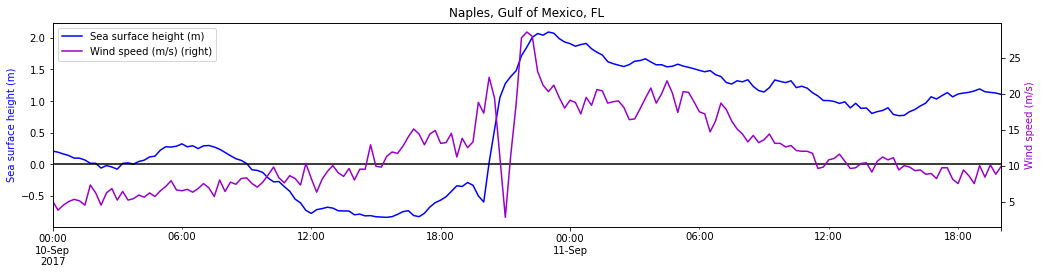

In [17]:
import matplotlib.pyplot as plt

try:
    station = "8725110"

    w = [obs for obs in winds_observations if obs._metadata["station_code"] == station][
        0
    ]
    s = [obs for obs in ssh_observations if obs._metadata["station_code"] == station][0]

    fig, ax = plt.subplots(figsize=(17, 3.75))
    s["2017-9-10":].plot(ax=ax, label="Sea surface height (m)", color="#0000ff")
    ax1 = w["2017-9-10":].plot(
        ax=ax, label="Wind speed (m/s)", color="#9900cc", secondary_y=True
    )
    ax.set_title(w._metadata["station_name"])

    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, [l.get_label() for l in lines], loc="upper left")
    ax.axhline(0, color="black")

    ax.set_ylabel("Sea surface height (m)", color="#0000ff")
    ax.right_ax.set_ylabel("Wind speed (m/s)", color="#9900cc")

    ax1.annotate(
        "Eye of the hurricane",
        xy=(w["2017-9-10":].argmin().to_pydatetime(), w["2017-9-10":].min()),
        xytext=(5, 10),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="simple", facecolor="crimson"),
    )

    ax.grid(True)
except Exception:
    print("Cannot find station {}".format(station))

We can observe the sea level retreating around 10-Sep 9:00 and then a significant surge after 19:00.
The lower winds at beginning of the surge is probably the eye of the hurricane.

For our interactive map we will use [`bokeh`](https://bokeh.pydata.org/en/latest) HTML plots instead of the usual raster [`matplotlib`](https://matplotlib.org) ones to enhance the user experience when exploring the graphs.

In [18]:
from bokeh.embed import file_html
from bokeh.models import HoverTool, LinearAxis, Range1d
from bokeh.plotting import figure
from bokeh.resources import CDN
from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(ssh, wind):
    p = figure(
        toolbar_location="above",
        x_axis_type="datetime",
        width=width,
        height=height,
        tools=tools,
        title=ssh.name,
    )

    p.yaxis.axis_label = "wind speed (m/s)"

    l0 = p.line(
        x=wind.index,
        y=wind.values,
        line_width=5,
        line_cap="round",
        line_join="round",
        legend_label="wind speed (m/s)",
        color="#9900cc",
        alpha=0.5,
    )

    p.extra_y_ranges = {}
    p.extra_y_ranges["y2"] = Range1d(start=-1, end=3.5)

    p.add_layout(LinearAxis(y_range_name="y2", axis_label="ssh (m)"), "right")

    l1 = p.line(
        x=ssh.index,
        y=ssh.values,
        line_width=5,
        line_cap="round",
        line_join="round",
        legend_label="ssh (m)",
        color="#0000ff",
        alpha=0.5,
        y_range_name="y2",
    )

    p.legend.location = "top_left"

    p.add_tools(
        HoverTool(
            tooltips=[
                ("wind speed (m/s)", "@y"),
            ],
            renderers=[l0],
        ),
        HoverTool(
            tooltips=[
                ("ssh (m)", "@y"),
            ],
            renderers=[l1],
        ),
    )
    return p


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width + 45, height=height + 80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color="green", icon="stats")
    marker = folium.Marker(location=location, popup=popup, icon=icon)
    return marker

Here is the final result. Explore the map by clicking on the map features plotted!

In [19]:
import folium
from folium.plugins import Fullscreen, MarkerCluster
from ioos_tools.ioos import get_coordinates

lon = track.centroid.x
lat = track.centroid.y

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=4)

Fullscreen(position="topright", force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name="Observations")
marker_cluster1 = MarkerCluster(name="Past predictions")
marker_cluster0.add_to(m)
marker_cluster1.add_to(m)


url = "http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km"
w0 = folium.WmsTileLayer(
    url,
    name="Sea Surface Temperature",
    fmt="image/png",
    layers="CRW_SST",
    attr="PacIOOS TDS",
    overlay=True,
    transparent=True,
)

w0.add_to(m)

url = "http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV"
w1 = folium.WmsTileLayer(
    url,
    name="HF Radar",
    fmt="image/png",
    layers="surface_sea_water_velocity",
    attr="HFRNet",
    overlay=True,
    transparent=True,
)

w1.add_to(m)


def style_function(feature):
    return {
        "fillOpacity": 0,
        "color": "black",
        "stroke": 1,
        "weight": 0.5,
        "opacity": 0.2,
    }


# Latest cone prediction.
latest = cones[-1]
folium.GeoJson(
    data=latest.__geo_interface__,
    name="Cone prediction as of {}".format(latest["ADVDATE"].values[0]),
).add_to(m)

# Past cone predictions.
for cone in cones[:-1]:
    folium.GeoJson(
        data=cone.__geo_interface__,
        style_function=style_function,
    ).add_to(marker_cluster1)

# Latest points prediction.
for k, row in pts.iterrows():
    date = row["FLDATELBL"]
    hclass = row["TCDVLP"]
    location = row["LAT"], row["LON"]
    popup = "{}<br>{}".format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=10,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)

# All the points along the track.
for point in points:
    date = point["FLDATELBL"]
    hclass = point["TCDVLP"]
    location = point["LAT"], point["LON"]
    popup = "{}<br>{}".format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=5,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)


# Observations.
for ssh, wind in zip(ssh_observations, winds_observations):
    fname = ssh._metadata["station_code"]
    location = ssh._metadata["lat"], ssh._metadata["lon"]
    p = make_plot(ssh, wind)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(marker_cluster0)

folium.LayerControl().add_to(m)

p = folium.PolyLine(get_coordinates(bbox), color="#009933", weight=1, opacity=0.2)

p.add_to(m);

In [20]:
m